In [2]:
#Import Libraries and Data Set 
library(readr)   
library(dplyr)   
library(ggplot2) 
library(reshape2)
library(tidyverse)
library(GGally)
library(reshape2)
library(glmnet)
library(tidymodels)
library(jsonlite)
library(repr)
library(leaps)

state_variable_data <- read_csv("state_variable_data.csv")
head(state_variable_data)

#filter numeric data 
numeric_data <- state_variable_data |>
  select_if(is.numeric)
  
numeric_data <- numeric_data |>
    select(-state, protests_per_100k, protests_per_100k, diversity_index, education_index, 
           economic_index, voter_turnout_2020, voter_turnout_2016)


Rows: 50 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): voted_2020
dbl (8): state, protests_per_100k, polarization_var, diversity_index, educat...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


state,voted_2020,protests_per_100k,polarization_var,diversity_index,education_index,economic_index,voter_turnout_2020,voter_turnout_2016
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Republican,7.284627,0.13333237,53.1,63.93333,78.68990,0.6146,0.5912
2,Republican,9.135645,0.02205297,62.8,70.33333,89.14633,0.6823,0.6156
4,Democrat,6.180520,0.19872212,61.5,65.83333,83.62785,0.6663,0.5597
5,Republican,6.740773,0.08151470,49.8,63.16667,76.76303,0.5617,0.5311
6,Democrat,13.905531,0.53408166,69.7,64.16667,87.07850,0.6883,0.5831
8,Democrat,7.707344,0.16659249,52.3,73.80000,89.97153,0.7669,0.7199


In [3]:
set.seed(123)
# Making the Model. We first split the data into training and testing sets

turnout_split <- initial_split(numeric_data, prop = 0.6, strata = voter_turnout_2020)
train_set <- training(turnout_split)
test_set <- testing(turnout_split)

# Then we create a vector that allocates each observation to one of k = 10 folds
k = 10
n <- nrow(train_set)
folds <- sample(rep(1:k, length = n))

# Create a matrix to store the results
cv.errors <- matrix(NA, k, 6, dimnames = list(NULL, paste(1:6)))

# Customize the predict function on regsubsets object
predict.regsubsets <- function(object, newdata , id, ...) {
    form <- as.formula(object$call[[2]])
    mat <- model.matrix(form, newdata)
    coefi <- coef(object, id = id)
    xvars <- names(coefi)
    mat[, xvars] %*% coefi
}

# For each fold
for(j in 1:k){
  # Fit the model with each subset of predictors on the training part of the fold
  best.fit=regsubsets(voter_turnout_2020~.,data=train_set[folds!=j,], method = "forward", nvmax=6) 
  # For each subset
  for(i in 1:6){
    # Predict on the hold out part of the fold for that subset
    pred=predict.regsubsets(best.fit, train_set[folds==j,],id=i)
    # Get the mean squared error for the model trained on the fold with the subset
    cv.errors[j,i]=mean((train_set$voter_turnout_2020[folds==j]-pred)^2)
  }
}

cat(("Table 3: The test MSE for the 10 cross-validation fold for the best ith variable model"))
head(cv.errors, 3)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 2 breaks instead.”


Table 3: The test MSE for the 10 cross-validation fold for the best ith variable model

1,2,3,4,5,6
8.597222e-05,8.055636e-05,7.144142e-05,7.531725e-05,9.604159e-05,7.991231e-05
3.635106e-04,1.088307e-03,1.604043e-03,1.732824e-03,1.695855e-03,2.131820e-03
9.633647e-04,9.195281e-04,2.922014e-04,2.533677e-04,2.818162e-04,4.792750e-04


In [3]:
mean.cv.errors <- apply(cv.errors, 2, mean)
meanCVE = as.data.frame(as.table(mean.cv.errors))
colnames(meanCVE) <- c("Number_of_variables", "cv_error_mean")

cat(("Table 4: The cross-validation error mean of the Forward Selection model with different number of variables"))
arrange(meanCVE, cv_error_mean)

Table 4: The cross-validation error mean of the Forward Selection model with different number of variables

Number_of_variables,cv_error_mean
<fct>,<dbl>
3,0.0004952911
4,0.0005179652
5,0.0005410533
1,0.0005549721
6,0.0006197919
2,0.0006437806


In [4]:
RMSE_models <- tibble(
  Method = "Forward Selection",
  RMSE = min(mean.cv.errors)^0.5
)
cat(("Table 5: RMSE corresponding to the Forward Selection method"))
RMSE_models

Table 5: RMSE corresponding to the Forward Selection method

Method,RMSE
<chr>,<dbl>
Forward Selection,0.02225514


### Ridge Regression

In [5]:
# Build matrix and vector required by `cv.glmnet`
X_train <- model.matrix(object = voter_turnout_2020 ~ .,
  data = train_set)[, -1]

Y_train <- train_set[["voter_turnout_2020"]]

X_test <- model.matrix(object = voter_turnout_2020 ~ .,
  data = test_set)[, -1]

Y_test <- test_set[["voter_turnout_2020"]]

# Use cross-validation to tune the parameter and fit the ridge model
cv_lambda_ridge <- cv.glmnet(
  x = X_train, y = Y_train,
  alpha = 0,
  lambda = exp(seq(-5, 10, 0.1)) 
    #standardize = TRUE : the default setting that helps standardize the predictors
)
cv_lambda_ridge


Call:  cv.glmnet(x = X_train, y = Y_train, lambda = exp(seq(-5, 10,      0.1)), alpha = 0) 

Measure: Mean-Squared Error 

      Lambda Index   Measure        SE Nonzero
min 0.006738   151 0.0004425 0.0001095       6
1se 0.016573   142 0.0005493 0.0001126       6

In [10]:
RMSE_models <- RMSE_models |>
    rbind(c("Ridge", min(cv_lambda_ridge$cvm)^0.5))
cat(("Table 6: RMSE corresponding to the Forward Selection and the Ridge Regression Model"))
RMSE_models

Table 6: RMSE corresponding to the Forward Selection and the Ridge Regression Model

Method,RMSE
<chr>,<chr>
Forward Selection,0.0222551372154188
Ridge,0.0210359391048723
Forward Selection (test),0.02616206429643
Ridge,0.0210359391048723


In [7]:
reg.best <- regsubsets(voter_turnout_2020 ~ ., data = train_set, nvmax = 6)

selected_var <- names(coef(reg.best, 2))[-1]

training_subset <- train_set %>% select(all_of(selected_var), voter_turnout_2020)

red_OLS <- lm(voter_turnout_2020 ~ ., data = training_subset)
summary(red_OLS)


Call:
lm(formula = voter_turnout_2020 ~ ., data = training_subset)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.047875 -0.009561  0.002443  0.010276  0.042989 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -0.032954   0.076491  -0.431   0.6700    
education_index     0.003576   0.001393   2.567   0.0161 *  
voter_turnout_2016  0.741650   0.065454  11.331 9.12e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01991 on 27 degrees of freedom
Multiple R-squared:  0.9154,	Adjusted R-squared:  0.9091 
F-statistic:   146 on 2 and 27 DF,  p-value: 3.321e-15


In [8]:
test_pred_red_OLS <- predict(red_OLS, newdata = test_set)

rmse_val <- sqrt(mean((test_pred_red_OLS - test_set$voter_turnout_2020)^2))

RMSE_models <- RMSE_models |>
    rbind(c("Forward Selection (test)",rmse_val))

cat(("Table 7: RMSE corresponding to diverse models"))
RMSE_models

Table 7: RMSE corresponding to diverse models

Method,RMSE
<chr>,<chr>
Forward Selection,0.0222551372154188
Ridge,0.0210359391048723
Forward Selection (test),0.02616206429643


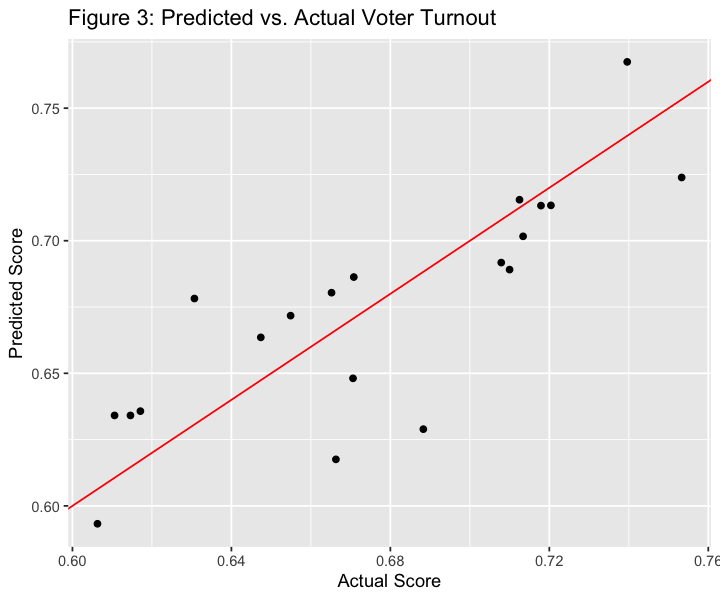

In [9]:
options(repr.plot.width=6, repr.plot.height=5)

ggplot(data = test_set, aes(x = voter_turnout_2020, y = test_pred_red_OLS)) + 
  geom_point() + 
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "Figure 3: Predicted vs. Actual Voter Turnout", x = "Actual Score", y = "Predicted Score")
     